In [11]:
%reset -f
%load_ext autoreload
%autoreload 2
%matplotlib inline

import os, sys
import numpy as np
import polytope as pc

sys.path.append(os.path.join(os.getcwd(), 'my_lib'))
from func_plot import *
from func_polytope import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Controllable set

制御周期$k$における状態量$x_k$、制御量$u_k$、制御量出力誤差$e_k$、システム外乱$w_k$が、任意の$k$において次のような集合に含まれるとする
\begin{equation}
x_k \in X, u_k \in U, e_k \in E, w_k \in W, \forall k \geq 0
\end{equation}
このときシステム更新式は次で表される
\begin{equation}
x_{k+1}=Ax_{k}+B_u (u_k+e_k)+B_w w_k \\ 
\end{equation}
このとき上記システム更新式での可制御集合（Controllable set）を$Pre(X,W)$とする。可制御集合はこのシステム状態が集合X内に制御されることが可能なシステム状態集合を意味する。集合X, Uを半空間表現して
\begin{equation}
X=\{x: Hx \leq h \}, U=\{u: H_u u \leq h_u \}
\end{equation}
とすると可制御集合は、
\begin{equation}
Pre(X,W) = \{x\in \mathbb{R}^2:
\begin{bmatrix}
HA & HB_u \\
O & H_u \\
\end{bmatrix}
\begin{bmatrix}
x \\ u
\end{bmatrix}
\leq
\begin{bmatrix}
h - HB_w w - HB_u e\\
h_u
\end{bmatrix}
, \forall w \in W\}
\end{equation}

In [12]:
def Pre(A, X, Bu, U, Bw=None, W=None, E=None):
    H, h  = X.A, X.b
    Hu,hu = U.A, U.b
    Hp = np.hstack([H@A, H@Bu])
    Hp = np.vstack([Hp, np.hstack([np.zeros([Hu.shape[0], A.shape[1]]),Hu])])
    h_ = np.array(h)
    if (Bw is not None) and (W is not None):
        h_ = h_ - np.max(H@Bw@extreme(W).T,axis=1)
    if (Bu is not None) and (E is not None):
        h_ = h_ - np.max(H@Bu@extreme(E).T,axis=1)
    hp = np.hstack([h_, hu])
    G = polytope_h(np.array(Hp),np.array(hp))
    return project(G, list(range(0,H.shape[1])))

## 不変集合（InvariantSet）

In [16]:
def InvariantSet(A, X, b, U, bw=None, W=None, fig=None):
    tol = 1e-3
    for i in range(100):
        X0 = X
        P  = Pre(A,X,b,U,bw,W)
        X  = intersect(P,X)
        
        if fig is not None:
            Xp = project(X,[0,1])
            Xp.plot(fig, alpha=1, color='None', edgecolor='black', linestyle='-', linewidth=1)

        if X0<=mul(X, 1+tol):
            print("\nInvariant set found on {0}-th iteration".format(i))
            return X

        if not (np.zeros(b.shape) in X):
            print("\nNo invariant set exist!")
            return X

        print("|", end="")

    print("\nInvariant set is still being computed!")
    return X


|||||||||||||||||
Invariant set found on 17-th iteration
|||||||||||||||||||
Invariant set found on 19-th iteration


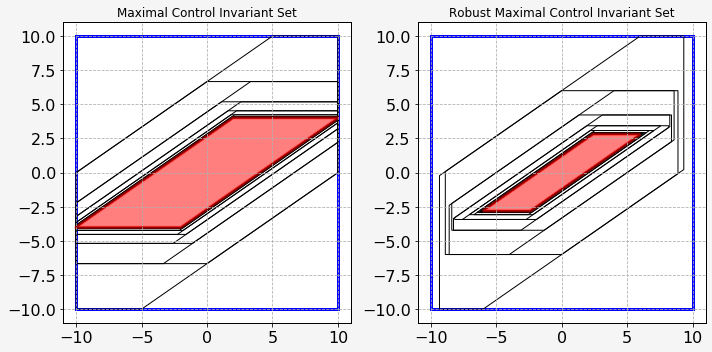

In [18]:
# システム定義
X = pc.box2poly([[-10, 10],[-10, 10]])
U = polytope_range(-5, 5)
W = polytope_range(-1, 1)

A = np.array([[1.5,0],[1,-1.5]])
b = np.array([[1],[0]])
bw = np.array([[1],[1]])

fig, ax = Fig(size=(10,5), col=2)
set_xlim(ax,[-11, 11])
set_ylim(ax,[-11, 11])
title(ax,"Maximal Control Invariant Set"
        ,"Robust Maximal Control Invariant Set")

# 初期集合
X.plot(ax[0], alpha=1, color='None', edgecolor='b', linestyle='-')
X.plot(ax[1], alpha=1, color='None', edgecolor='b', linestyle='-')

# 不変集合演算
C_inf = InvariantSet(A, X, b, U, fig=ax[0])
O_inf = InvariantSet(A, X, b, U, bw, W, fig=ax[1])

C_inf.plot(ax[0], alpha=0.5, color='r', edgecolor='r', linestyle='-');
O_inf.plot(ax[1], alpha=0.5, color='r', edgecolor='r', linestyle='-');